Calculate prefered stimuli at each layer using gradient descent with a patched Lucent.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
from paths import *
sys.path.append(CPC_DPC)
sys.path.append(CPC_BACKBONE)

from python_dict_wrapper import wrap

features = 'airsim_04'

args = wrap({'features': features,
             'ckpt_root': CHECKPOINTS,
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})

from models import get_feature_model

model, hooks, data = get_feature_model(args)

In [4]:
model

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [6]:
import lucentpatch
import lucentpatch.transform

from lucentpatch.render import render_vis
from lucentpatch.objectives import neuron, slow, tv_slow, intensity_preservation
from lucent.optvis.objectives import channel
from lucent.optvis import param
import lucent
import lucent.optvis
import lucent.optvis.transform

import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def get_anim(result, size=4, norm=False):
    fig = plt.figure(figsize=(size, size))
    ax = plt.gca()
    im = plt.imshow([[1]])
    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0)

    rg = None
    if norm:
        rg = [result.min(), result.max()]

    def drawframe(n):
        if n >= nt:
            n = nt - 1
        else:
            im.set_data(result.transpose((2, 3, 1, 0))[:, :, :, n])
        if norm:
            im.set_clim(rg)
        return (im)

    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=nt*2, interval=100, blit=False)
    plt.close()
    return anim

npixels = 112

for layer_name, max_filt in [('s1_pool_layer', 64), ('res0_relu', 32), ('res1_relu', 32)]:
    for filt in range(max_filt):
        nt = 7
        device = 'cuda'

        # Most important layers: layer2_1_relu, layer3_0_relu, layer3_1_relu
        obj = neuron(layer_name, filt, (1, 1)) #+ 2 * slow('input') + 2 * tv_slow('input') #+ 5 * intensity_preservation('input', 112 // 4, 112)

        # sd = None converges faster, but some filters are 0.
        for sd in [None, .1, .15]:
            batch_param_f = lambda: param.image(npixels, batch=nt, fft=False, sd=sd)
            model = model.to(device).eval()
            result = render_vis(model, 
                                obj, 
                                batch_param_f, 
                                show_image=False, 
                                show_inline=False, 
                                thresholds=(512,), 
                                fixed_image_size=True,
                                preprocess=False,
                                transforms=[lucentpatch.transform.normalize(),
                                            lucent.optvis.transform.pad(12, mode="constant", constant_value=0.5),
                                            lucent.optvis.transform.jitter(8),
                                            lucent.optvis.transform.random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
                                            lucent.optvis.transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
                                            lucent.optvis.transform.jitter(4),
                                            #lucentpatch.transform.loop(3)
                                            ],
                                )

            if result[0].std() > .01 or sd == .15: 
                anim = get_anim(result[0], npixels / 72)
                anim.save(f'figures/{features}_{layer_name}_{filt}.gif', writer='imagemagick', fps=12, bitrate=10000)
                plt.imsave(f'figures/{features}_{layer_name}_{filt}.png', result[0][4, :, :, :].transpose((1, 2, 0)))
                break

100%|██████████| 512/512 [01:29<00:00,  5.75it/s]


Generate quiver plots from reverse correlation stimuli.

In [2]:
import pickle
with open('rc_big.pkl', 'rb') as f:
    data = pickle.load(f)

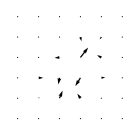

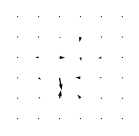

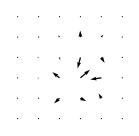

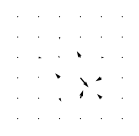

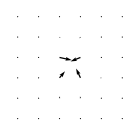

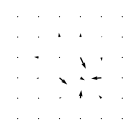

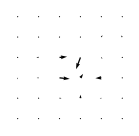

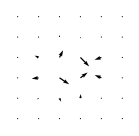

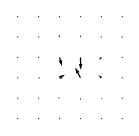

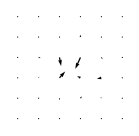

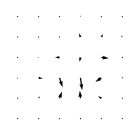

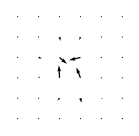

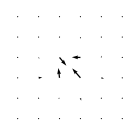

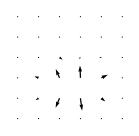

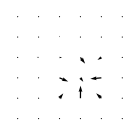

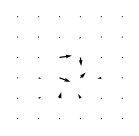

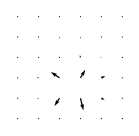

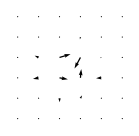

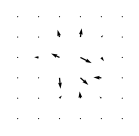

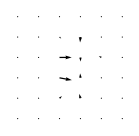

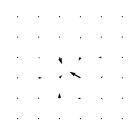

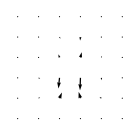

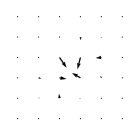

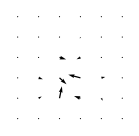

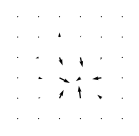

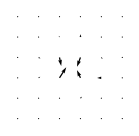

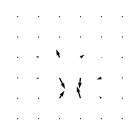

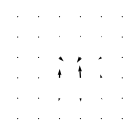

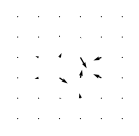

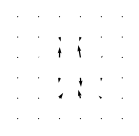

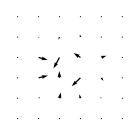

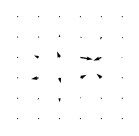

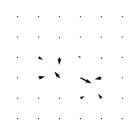

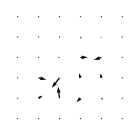

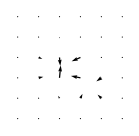

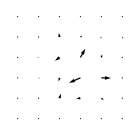

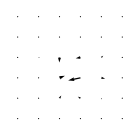

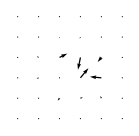

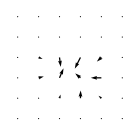

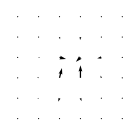

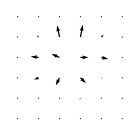

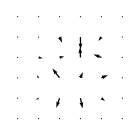

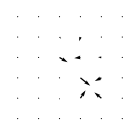

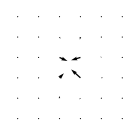

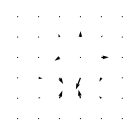

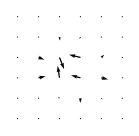

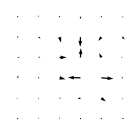

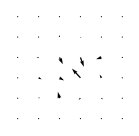

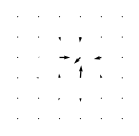

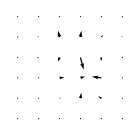

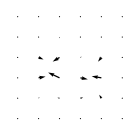

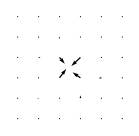

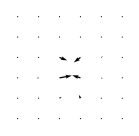

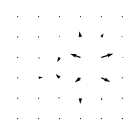

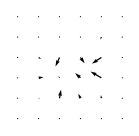

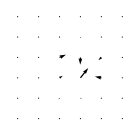

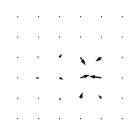

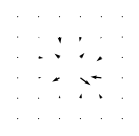

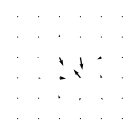

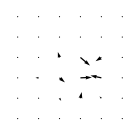

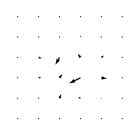

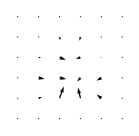

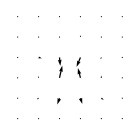

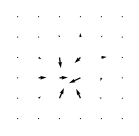

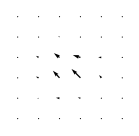

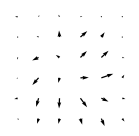

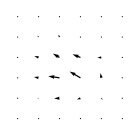

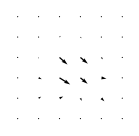

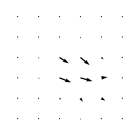

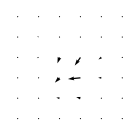

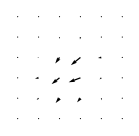

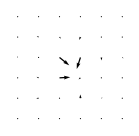

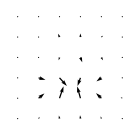

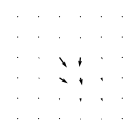

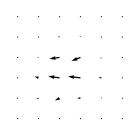

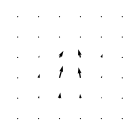

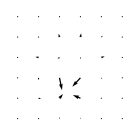

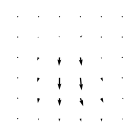

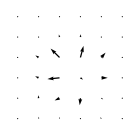

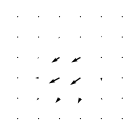

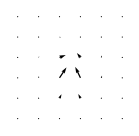

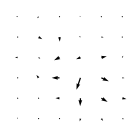

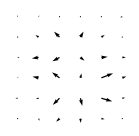

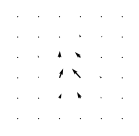

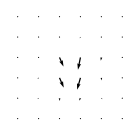

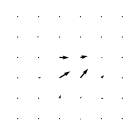

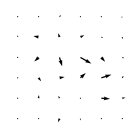

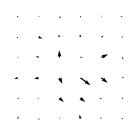

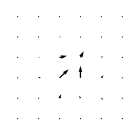

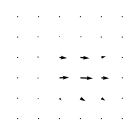

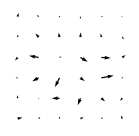

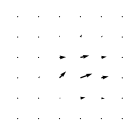

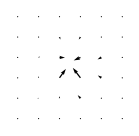

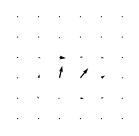

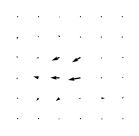

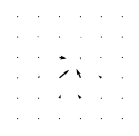

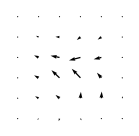

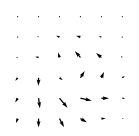

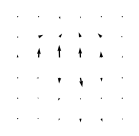

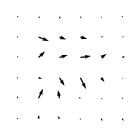

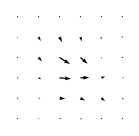

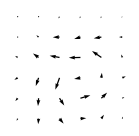

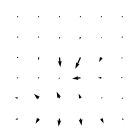

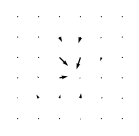

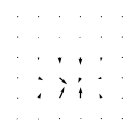

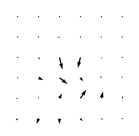

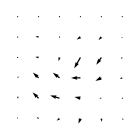

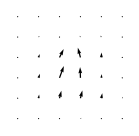

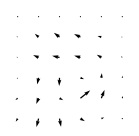

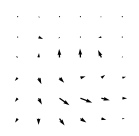

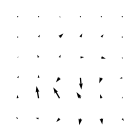

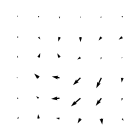

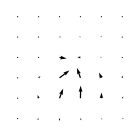

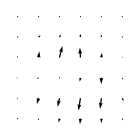

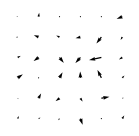

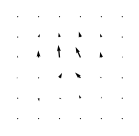

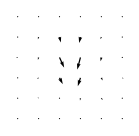

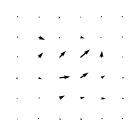

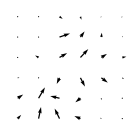

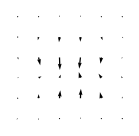

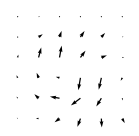

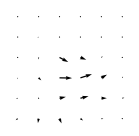

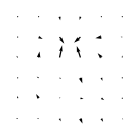

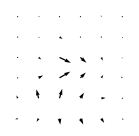

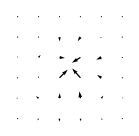

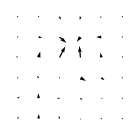

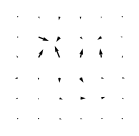

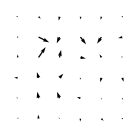

In [10]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

features = 'airsim_04'

for layer_name, max_filt in [('layer01', 64), ('layer02', 32), ('layer03', 32)]:
    for filt in range(max_filt):
        xx = data[layer_name][filt, :, :, 0]
        yy = data[layer_name][filt, :, :, 1]
        maxa = 10*np.sqrt(xx ** 2 + yy ** 2).max()
        plt.figure(figsize=(2.25, 2.25))
        plt.quiver(xx, yy, scale=maxa, width=.01)
        plt.xlim([10.5, 16.5])
        plt.ylim([16.5, 10.5])
        plt.box(False)
        plt.axis(False)
        plt.savefig(f'/home/pmin/paper-assets/tuningcurves/{features}_{layer_name}_{filt}_quiver.svg')
        plt.savefig(f'/home/pmin/paper-assets/tuningcurves/{features}_{layer_name}_{filt}_quiver.png')
        plt.show()